In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from sklearn import preprocessing
from sklearn.linear_model import Ridge
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.cm as cm
from helpers import *

# Products and emissions: global overview

## Products impact on global emissions

In this section of the project, we try to assess the impact of different categories of products on emissions quantities (aggregate data for agricultural activities), i.e. evaluate how much each category contributes to the emissions agriculture produces overall.

It is well known that some foods have a much more significant impact on emissions than others: this aspect is sometimes called the *carbon footprint*. For example, a kilogram of meat causes, during its production (which includes feeding and taking care of the animal, but also the animal's own emissions), a much higher CO2 equivalent emission amount with respect to, e.g. a kilogram of cereal crops.

There is no direct way to compute the carbon footprint: these values are usually built up by imputation of emissions values to the different products, according to various parameters (often derived from technical knowledge in the field). Since we only have aggregate data, we try a different approach, namely apply Machine Learning techniques.

Let's start by collecting data we need. We decide to aggregate production quantities at a global level: the reason is that internationl trading (ref. TradeNetwork.ipynb) and an overall dishomogeneity in production volumes and composition (in terms of categories of products) among different countries would lead to high volatile and thus completely useless model parameters. We actually tried hard with this approach, to make a comparison between countries possible, but we failed in producing interesting insights.

In [2]:
# Load and reformat dataset: Crops global production
crops_production = pd.read_pickle("pickle/crops_production.pkl")
crops_production = crops_production.stack().unstack(level=1)
crops_production = crops_production.reset_index().rename(columns={'level_1':'Year'})
crops_production = crops_production.groupby('Year').sum()
crops_production.head()

Item,"Cereals,Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Vegetables Primary
Year,,,,,,,
Y1961,865354278.0,14991919.0,195728067.0,25542522.0,40294799.0,450218171.0,195381650.0
Y1962,920899120.0,15388579.0,212896393.0,26179055.0,45636444.0,443689550.0,194316655.0
Y1963,936153284.0,16610805.0,209897655.0,27738432.0,44233043.0,458202649.0,194793616.0
Y1964,986561618.0,17119711.0,220504429.0,28141956.0,46356207.0,473360185.0,197168359.0
Y1965,985164222.0,18110102.0,226056501.0,29447454.0,44860853.0,479594376.0,200255755.0


In [3]:
# Load and reformat dataset: Livestock global production
livestock_production = pd.read_pickle("pickle/livestock_production.pkl")
livestock_production = livestock_production.stack().unstack(level=1)
livestock_production = livestock_production.reset_index().rename(columns={'level_1':'Year'})
livestock_production = livestock_production.groupby('Year').sum()
livestock_production.head()

Item,Beef and Buffalo Meat,Eggs Primary,"Meat, Poultry","Milk,Total",Sheep and Goat Meat
Year,,,,,
Y1961,28364712.0,14837131.0,8779258.0,337516459.0,5977575.0
Y1962,29844698.0,15211552.0,9024244.0,340189464.0,6104303.0
Y1963,31503200.0,15391955.0,9562049.0,337822653.0,6109981.0
Y1964,32016133.0,16055825.0,9940699.0,343112498.0,6107359.0
Y1965,32620631.0,16571118.0,10747470.0,358282441.0,6157696.0


In [4]:
# Define available years
years = ['Y'+str(x) for x in range(1964,2015)]

In [5]:
# Products matrix
X = crops_production.join(livestock_production).loc[years]
X.head()

Item,"Cereals,Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Vegetables Primary,Beef and Buffalo Meat,Eggs Primary,"Meat, Poultry","Milk,Total",Sheep and Goat Meat
Year,,,,,,,,,,,,
Y1964,9.865616e+08,17119711.0,220504429.0,28141956.0,46356207.0,473360185.0,197168359.0,32016133.0,16055825.0,9940699.0,343112498.0,6107359.0
Y1965,9.851642e+08,18110102.0,226056501.0,29447454.0,44860853.0,479594376.0,200255755.0,32620631.0,16571118.0,10747470.0,358282441.0,6157696.0
Y1966,1.061950e+09,17559159.0,231289479.0,30569838.0,40561401.0,501118864.0,207261641.0,34282717.0,17005626.0,11452987.0,366709318.0,6262299.0
Y1967,1.107745e+09,17235529.0,242730075.0,31504594.0,39628580.0,519783940.0,214325924.0,35990692.0,17814137.0,12138540.0,374827966.0,6433193.0
Y1968,1.145631e+09,17040599.0,249300863.0,32456838.0,41918972.0,532240413.0,220161224.0,37687956.0,18286269.0,12516493.0,383027546.0,6606892.0


In [6]:
# Load and reformat dataset: Crops emissions
emissions_crops = pd.read_pickle("pickle/emissions_crops.pkl")
emissions_crops = emissions_crops.stack().reset_index().rename(columns={'level_1':'Year'})
emissions_crops = emissions_crops.groupby('Year').sum().drop('Recent').rename(columns={0:'Emissions'})

In [7]:
# Load and reformat dataset: Livestock emissions
emissions_livestock = pd.read_pickle("pickle/emissions_livestock.pkl")
emissions_livestock = emissions_livestock.stack().reset_index().rename(columns={'level_1':'Year'})
emissions_livestock = emissions_livestock.groupby('Year').sum().drop('Recent').rename(columns={0:'Emissions'})

In [8]:
# Total emissions
emissions = emissions_crops + emissions_livestock
y = emissions.loc[years,:]
y.head()

,Emissions
Year,
Y1964,5.750371e+06
Y1965,5.870623e+06
Y1966,6.025515e+06
Y1967,6.165594e+06
Y1968,6.284917e+06


At this point, we have defined:
* X: Design matrix, which contains for each year the global production amount (in tonnes) for a number of categories of products, both in crops and livestock areas.
* y: response vector, which contains for each year the total amount of emissions on a global level (in CO2 equivalent Gigagrams).

Before proceeding in fitting a model on our data, we perform other two preprocessing operations:
* normalize the product matrix using a MinMaxScaler;
* multiply the emissions vector by a factor 1000, in order to work with consistent units of measure (tonnes).

In [9]:
# Rescale data using MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X.values)
X_scaled = pd.DataFrame(X_scaled)

In [10]:
# Rescale emissions vector
y = y*1000

What we are going to do now is to fit a Ridge Regression on these data. This approach has pros and cons, some of those are discussed here.
* *Interpretability*: coefficients provided by this model are fully interpretable, as they simply correspond to the unit of emission for unit of production (e.g. how much a kilogram of that product causes in terms of emissions in CO2 equivalent kilogram terms).
* *Linear assumption*: by fitting a linear model, we are assuming a linear relation between emissions and production quantities, while this relation could not be linear at all!

Interpretability is a key factor for the purpouses of this section, as some interesting insights and conclusions may be drawn by using those coefficients appropriately. On the other hand, the linear assumption may be wrong, an probably is: for reference, it is well known that in contexts related to production, economic theories usually adopts concave functions. 

Let's have a look at the variability of our data.

In [11]:
(X.max()/X.min()).sort_values(ascending=False)

Item
Meat, Poultry               11.367807
Oilcrops, Oil Equivalent     7.275501
Vegetables Primary           5.230226
Eggs Primary                 4.715348
Fruit Primary                3.802908
Cereals,Total                2.854911
Sheep and Goat Meat          2.359407
Milk,Total                   2.311768
Beef and Buffalo Meat        2.152098
Pulses,Total                 1.975597
Fibre Crops Primary          1.883295
Roots and Tubers,Total       1.833538
dtype: float64

We can see how, apart from few features (e.g. `Meat, Poultry` and `Oilcrops`), the maximum production amount for each product category is 2 or 3 times the minimum amount. This means that we could think of fitting a linear regressions as a first-order *local* approximation of the true relationship: with this perspective, our choice could make sense.

In [12]:
# Perform RidgeRegression
RidgeR = Ridge().fit(X_scaled,y)
beta = pd.Series(RidgeR.coef_[0])
beta.index = X.columns

In order to obtain meaningful coefficients (i.e. kg of CO2 equivalent emission for kg of production), we need to *normalize back* our data.

In [13]:
# Normalize back
delta = X.max()-X.min()
beta = beta/delta
beta = beta.sort_values(ascending=False)
beta

Item
Sheep and Goat Meat         77.698887
Fibre Crops Primary         30.713559
Beef and Buffalo Meat       29.879921
Eggs Primary                 9.370615
Pulses,Total                 5.798563
Meat, Poultry                2.765946
Milk,Total                   0.725131
Cereals,Total                0.451830
Fruit Primary                0.297418
Vegetables Primary           0.072502
Roots and Tubers,Total       0.033802
Oilcrops, Oil Equivalent    -0.071492
dtype: float64

The coefficients we obtain appear to make sense: for comparison with coeffients usually considered for assessing *carbon footprint*, computed using imputation methods, you can have a look [here](https://www.businessinsider.com/the-top-10-foods-with-the-biggest-environmental-footprint-2015-9?r=US&IR=T). Note that values reported in the source include emissions due to transportation, and do not assess the role of `Fibre Crops Primary`, i.e. natural fibres like cotton which are not used for nutrition purposes.

The only concern could be about the negative coefficient assigned to the category `Oilcrops`: we can assume that this coefficient, as well as the coefficients relative to `Roots and Tubers` and `Vegetables Primary`, are not significant for our analysis, and set them to zero. Actually, we cannot reject the hypothesis that those coefficients are null, even if this would not make sense in practice (you clearly cannot reduce CO2 emissions by producing more Oil!).

In [14]:
# non-significant products
to_drop = ['Vegetables Primary','Roots and Tubers,Total','Oilcrops, Oil Equivalent']

Text(0.5, 0, '')

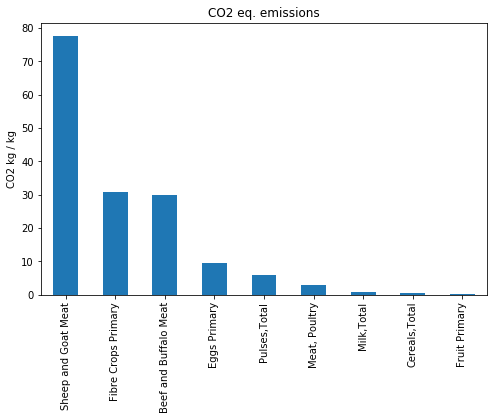

In [15]:
# Coefficients barplot
fig, ax = plt.subplots(figsize=(8,5))
beta.drop(to_drop).plot.bar(ax=ax)
ax.set_title('CO2 eq. emissions')
ax.set_ylabel('CO2 kg / kg')
ax.set_xlabel('')

## Products and individual consumption

Looking at the results of the previous section, one is tempted to rank products according to their carbon footprint. While this is certainly a good insight, it is also important to consider which amount of each category of products we actually consume in our daily life.

Therefore we compute, for each category of products and each year, the total global consumption per capita, i.e. which amount of each of those products the average individual consume each year.

Note that data are reported in kg/year.

In [16]:
# Load population data
population = pd.read_pickle("pickle/population.pkl")
population = population.loc['World',years]*1e3

In [17]:
# Compute per capita consumption
consumption_prod = X.apply(lambda x: x/population)
consumption_prod.index = consumption_prod.index.str.replace('Y','')
consumption_prod.head()

Item,"Cereals,Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Vegetables Primary,Beef and Buffalo Meat,Eggs Primary,"Meat, Poultry","Milk,Total",Sheep and Goat Meat
Year,,,,,,,,,,,,
1964,350.079688,6.074900,78.245616,9.986125,16.449420,167.971045,69.964852,11.360870,5.697382,3.527440,121.752878,2.167186
1965,342.103649,6.288832,78.499353,10.225789,15.578176,166.541763,69.539903,11.327692,5.754411,3.732118,124.415532,2.138294
1966,360.848598,5.966566,78.591690,10.387568,13.782681,170.279162,70.427080,11.649197,5.778477,3.891701,124.607074,2.127916
1967,368.490295,5.733382,80.743919,10.479972,13.182408,172.905613,71.295307,11.972268,5.925855,4.037873,124.686152,2.139995
1968,372.983886,5.547919,81.165039,10.566993,13.647586,173.281847,71.678028,12.270092,5.953472,4.075003,124.702520,2.151010


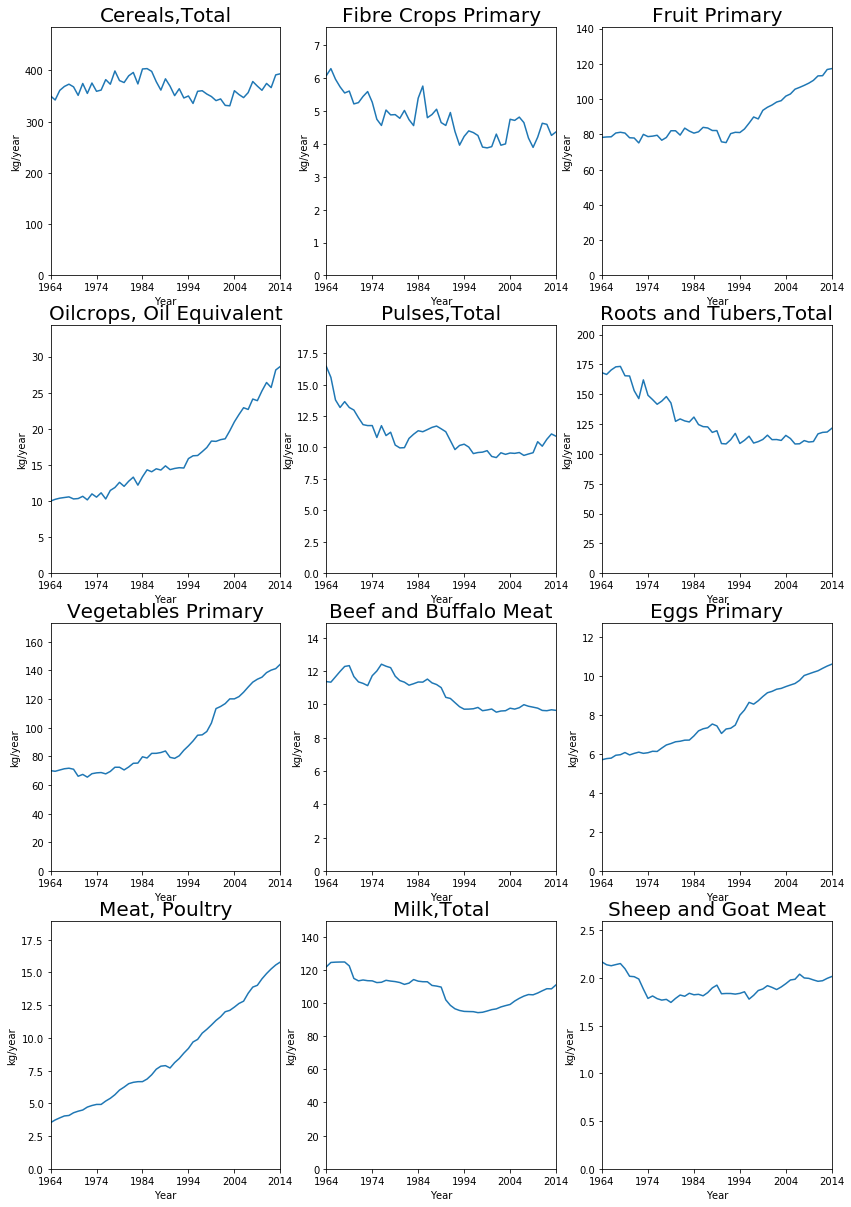

In [18]:
# Plots
fig, axes = plt.subplots(4,3, figsize=(14,21))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    product = consumption_prod[consumption_prod.columns[idx]]
    ax.set_title(product.name, fontsize=20)
    ax.set_ylim(0,product.max()*1.2)
    ax.set_ylabel('kg/year')
    product.plot.line(ax=ax)

These plots clearly show how per capita consumptions vary considerably among different categories of products, while are more or less stable in time in the last 50 years, with the soundly exception of poultry meat. This means that looking at pure carbon footprint coefficients is not enough: one should also consider the quantity we consume for each category of products.

We report here the average per capita annual consumptio for each category in the last 20 years.

In [19]:
# Recent years
rec_years = [str(x) for x in range(1994,2015)]

In [20]:
# Per capita consumption
cons = consumption_prod.loc[rec_years,:].mean()
cons.sort_values(ascending=False)

Item
Cereals,Total               357.358508
Vegetables Primary          118.646420
Roots and Tubers,Total      112.755592
Fruit Primary               100.777420
Milk,Total                  100.720401
Oilcrops, Oil Equivalent     21.268757
Meat, Poultry                12.526233
Pulses,Total                  9.838684
Beef and Buffalo Meat         9.712987
Eggs Primary                  9.443606
Fibre Crops Primary           4.295627
Sheep and Goat Meat           1.929198
dtype: float64

This data show how per capita consumption of `Cereals` is by far the highest among the categories considered here: `Vegetables` and `Fruit` are also very much consumed, as well as `Roots and Tubers` (basically potatoes). Interestingly enough, the category with the highest carbon footprint (`Sheep and Goat Meat`) is the less consumed among those considered. 

This clearly explains our comment at the beginning of this section: while `Sheep and Goat Meat` is by far the most *emitting* category, the emissions related to these products are actually less relevant than those related to other categories which have smaller carbon footprint coefficients but are far more consumed.

The average composition of individual annual total consumption of agricultural products in the last 20 years is show below using a pie chart.

Text(0, 0.5, '')

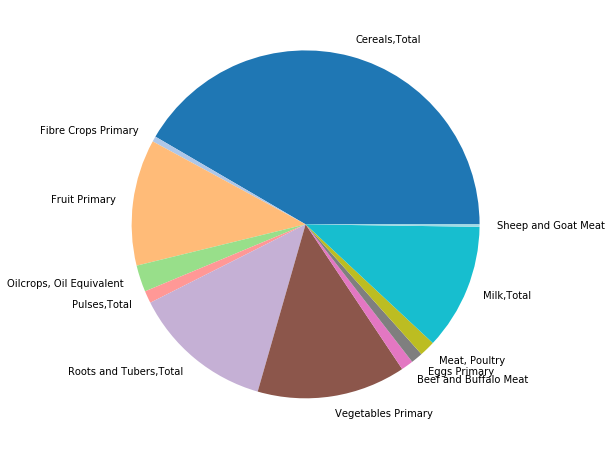

In [21]:
# Pie chart
fig, ax = plt.subplots(figsize=(12,8))
cons.plot.pie(ax=ax,cmap=cm.tab20)
ax.set_ylabel('')

## Conclusion: individual emissions for each category of products

Given the results obtained above, we are now able to assess with much more awareness the real impact of individual choices in food consumption on global emissions.

We now simply multiply pro capite consumption for each category of products with the corresponding carbon footprint coefficient, in order to obtain a clearer view on how much each product contributes to pro capite emissions values.

In [22]:
# Per capita emissions
emissions_prod = consumption_prod.apply(lambda x: x*beta, axis=1)
emissions_prod.head()

Item,Beef and Buffalo Meat,"Cereals,Total",Eggs Primary,Fibre Crops Primary,Fruit Primary,"Meat, Poultry","Milk,Total","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Sheep and Goat Meat,Vegetables Primary
Year,,,,,,,,,,,,
1964,339.461881,158.176469,53.387969,186.581800,23.271658,9.756709,88.286810,-0.713923,95.382994,5.677761,168.387926,5.072596
1965,338.470539,154.572656,53.922369,193.152406,23.347124,10.322837,90.217583,-0.731057,90.331029,5.629449,166.143027,5.041787
1966,348.077080,163.042185,54.147879,183.254486,23.374587,10.764237,90.356477,-0.742623,79.919739,5.755780,165.336733,5.106109
1967,357.730422,166.494932,55.528904,176.092559,24.014699,11.168541,90.413819,-0.749229,76.439019,5.844560,166.275253,5.169057
1968,366.629364,168.525271,55.787693,170.396327,24.139947,11.271238,90.425687,-0.755450,79.136384,5.857277,167.131083,5.196805


Text(0, 0.5, 'CO2 kg / person')

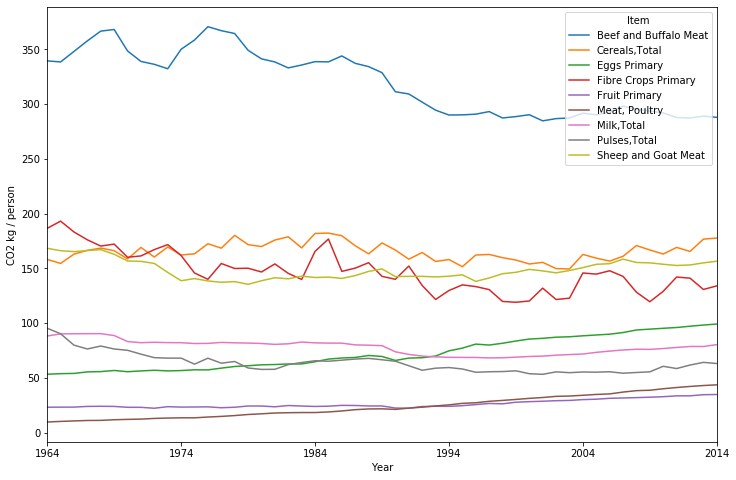

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
to_drop = ['Vegetables Primary','Roots and Tubers,Total','Oilcrops, Oil Equivalent']
emissions_prod.drop(columns=to_drop).plot.line(ax=ax)
ax.set_ylabel('CO2 kg / person')

We now see how the larger part of emissions caused by individual consumption is actually due to `Beef and Buffalo Meat`. `Cereals` also have an important role: even if their impact per kilogram is not high, the large amount of cereals we consume makes contribute consistently to global emissions.

We can have a look at the composition of per capita emissions related to each category of products in the pie chart below.

Text(0, 0.5, '')

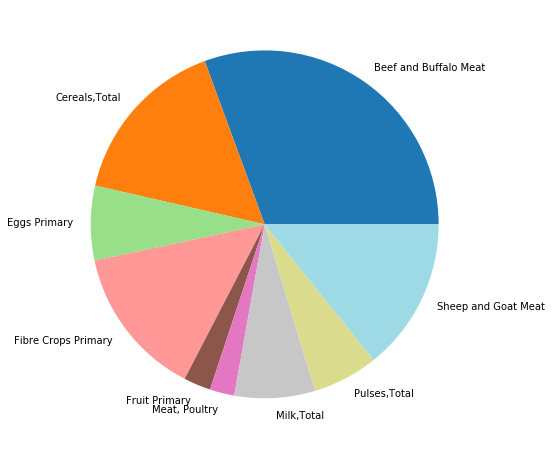

In [24]:
# Pie chart
fig, ax = plt.subplots(figsize=(12,8))
emissions_prod.drop(columns=to_drop).mean().plot.pie(ax=ax,cmap=cm.tab20)
ax.set_ylabel('')

Clearly, this analyses are not enough to draw definitive conclusions on how individuals and institutions should act to overall reduce global emissions. 

First of all, agriculture emissions are just a small part of the total emissions humans are producing with their activities: industrial emissions are usually far more important and attract more attention from general public, also because food production is seen as a basic need, and thus questioning about its impact on global emissions is harder with respect to e.g. industrial production.

Moreover, one shoud take into account a number of different factors:
* which of these categories of products are more important for human nutrition?
* how much we can reduce emissions related to e.g. Meat production without lowering the total amount produced or the quality of the product?
* are there countries which are particularly good or bad as for emissions / production ratio?
* what is the role of natural resources in production efficiency?

### Appendix: prepare data for website animation

In [25]:
# Load dataset
crops_production = pd.read_pickle("pickle/crops_production.pkl")
livestock_production = pd.read_pickle("pickle/livestock_production.pkl")
population = pd.read_pickle("pickle/population.pkl")

In [ ]:
# Save matrices
products = ['Beef and Buffalo Meat','Sheep and Goat Meat','Eggs Primary','Fibre Crops Primary','Cereals,Total']
for p in products:
    p = p.replace(' ','')
    if p in crops_production.reset_index().Item.unique():
        prod = crops_production.reset_index()
        prod = prod[prod.Item==p].drop('Item',axis=1).groupby('Area').sum()[years]
        countries = crops_production.reset_index().Area
    else:
        prod = livestock_production.reset_index()
        prod = prod[prod.Item==p].drop('Item',axis=1).groupby('Area').sum()[years]
        countries = livestock_production.reset_index().Area
    prodpc = prod/population.loc[countries,years]
    prodpc = prodpc.replace(np.inf,0)
    prodpc = prodpc.dropna()*1e-3
    prodpc.to_pickle("pickle/Matrix " + p + ".pkl")